In [4]:
"""
Inpainting CMB example: TQU
"""

'\nInpainting CMB example: TQU\n'

In [5]:
import numpy as np, sys, os, tools, scipy as sc, inpaint
import flatsky, tools
#%load_ext autoreload
#%autoreload 2

#%pylab notebook
%matplotlib inline
from pylab import *
from matplotlib import rc;rc('text', usetex=True);rc('font', weight='bold');matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
rcParams["figure.facecolor"] = 'white'
cmap = cm.RdYlBu

In [6]:
rcParams['figure.dpi'] = 150
rcParams['font.family'] = 'Times new roman'

In [7]:
#params or supply a params file
dx = 1.0
boxsize_am = 200. #boxsize in arcmins
nx = int(boxsize_am/dx)
mapparams = [nx, nx, dx, dx]
x1,x2 = -nx/2. * dx, nx/2. * dx
verbose = 0
pol = 1
#lmax = 10000
#el = np.arange(lmax)

#beam and noise levels
noiseval = 2.0 #uK-arcmin
if pol:
    noiseval = [noiseval, noiseval * np.sqrt(2.), noiseval * np.sqrt(2.)]
beamval = 1.4 #arcmins

#CMB power spectrum
#Cls_file = 'data/Cl_Planck2018_camb.npz'
Cls_file = 'data/output_planck_r_0.0_2015_cosmo_lensedCls.dat'
Tcmb = 2.73

#for inpainting
noofsims = 1000
mask_radius_inner = 4.0 #arcmins
mask_radius_outer = 20.0 #arcmins
mask_inner = 0  #If 1, the inner region is masked before the LPF. Might be useful in the presence of bright SZ signal at the centre.

In [8]:
#get ra, dec or map-pixel grid
ra = np.linspace(x1,x2, nx) #arcmins
dec = np.linspace(x1,x2, nx) #arcmins
ra_grid, dec_grid = np.meshgrid(ra,dec)

In [9]:
#read Cls now
'''
if (0):
    #els, Dls = np.loadtxt(Cls_file, usecols = [0,1], unpack = 1)
    Cls_rec = np.load(Cls_file, allow_pickle=1, mmap_mode='r')
    #print(Cls_rec.files);sys.exit()
    el = Cls_rec['L']
    cl = Cls_rec['TT']* 1e12 #Cls in uK

    #Dls_fac = els * (els + 1) / 2 / np.pi
    #Cls = Cls * Dls_fac
'''
#read Cls now
el, dl_tt, dl_ee, dl_bb, dl_te  = np.loadtxt(Cls_file, unpack = 1)
dl_all = np.asarray( [dl_tt, dl_ee, dl_bb, dl_te] )
dl_fac = el * (el + 1) / 2 / np.pi
cl_all = ( Tcmb**2. * dl_all ) / ( dl_fac )
cl_all = cl_all * 1e12
cl_tt, cl_ee, cl_bb, cl_te = cl_all #Cls in uK
cl = cl_tt
cl_dic = {}
cl_dic['TT'], cl_dic['EE'], cl_dic['BB'], cl_dic['TE'] = cl_tt, cl_ee, cl_bb, cl_te

if not pol:
    cl = [cl_tt]    
else:
    cl = cl_all
#loglog(el, cl_tt)
print(len(el))

19963


In [10]:
#get beam and noise
bl = tools.get_bl(beamval, el, make_2d = 1, mapparams = mapparams)
nl_dic = {}
if pol:
    nl = []
    for n in noiseval:
        nl.append( tools.get_nl(n, el) )
    nl = np.asarray( nl )
    nl_dic['T'], nl_dic['P'] = nl[0], nl[1]
else:
    nl = [tools.get_nl(noiseval, el)]
    nl_dic['T'] = nl[0]
print(nl_dic)

{'T': array([3.384638e-07, 3.384638e-07, 3.384638e-07, ..., 3.384638e-07,
       3.384638e-07, 3.384638e-07]), 'P': array([6.769276e-07, 6.769276e-07, 6.769276e-07, ..., 6.769276e-07,
       6.769276e-07, 6.769276e-07])}


Text(0.5, 0, 'Multipole $\\ell$')

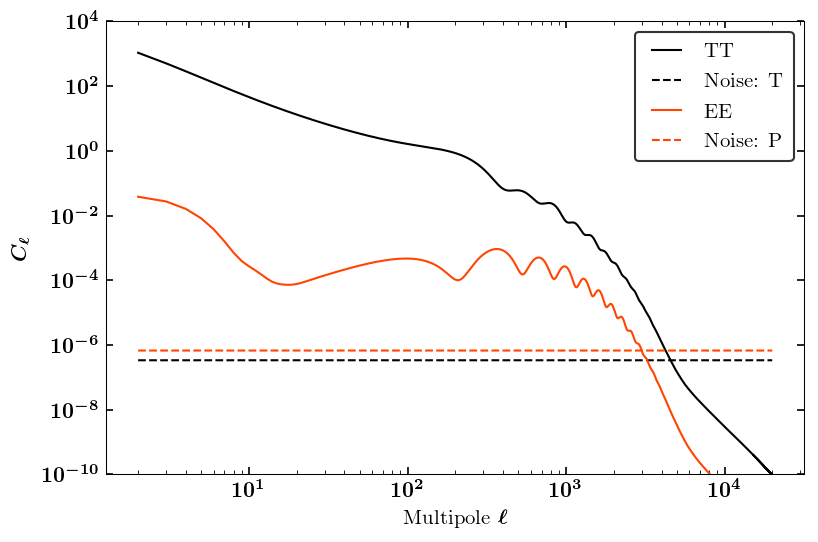

In [11]:
#plot
ax =subplot(111, yscale = 'log', xscale = 'log')
plot(el, cl[0], color = 'black', label = r'TT')
plot(el, nl[0], color = 'black', ls ='--', label = r'Noise: T')
if pol:
    plot(el, cl[1], color = 'orangered', label = r'EE')
    plot(el, nl[1], color = 'orangered', ls ='--', label = r'Noise: P')
legend(loc = 1)
ylim(1e-10, 1e4)
ylabel(r'$C_{\ell}$')
xlabel(r'Multipole $\ell$')

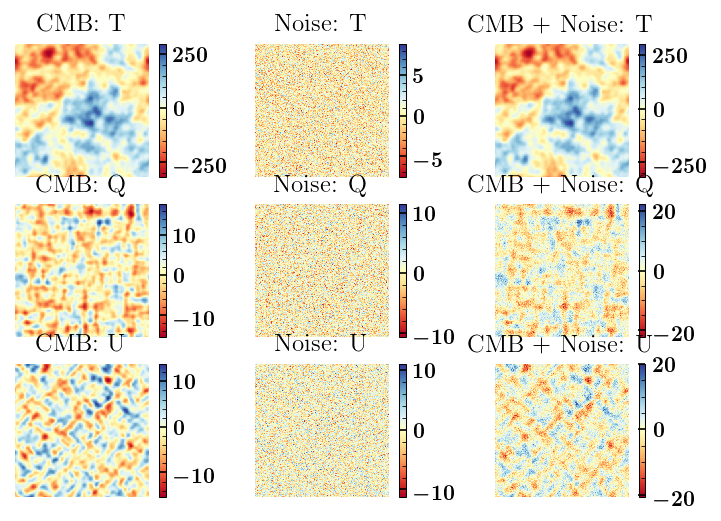

In [12]:
#create CMB and convolve with beam
clf()
subplots_adjust(hspace = 0.2, wspace = 0.1)
pol = 1
if not pol:
    cmb_map = np.asarray( [flatsky.make_gaussian_realisation(mapparams, el, cl[0], bl = bl)] )
    noise_map = np.asarray( [flatsky.make_gaussian_realisation(mapparams, el, nl[0])] )
    sim_map = cmb_map + noise_map
    subplot(131);imshow(cmb_map[0], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'CMB')
    axis('off')
    subplot(132);imshow(noise_map[0], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'Noise')
    axis('off')
    subplot(133);imshow(sim_map[0], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'CMB + Noise')
    axis('off')
else:
    #now pass cl_TT, cl_EE, cl_TE to make_gaussian_realisation function

    if (1):#get TQU sims
        cmb_map = flatsky.make_gaussian_realisation(mapparams, el, cl[0], cl2 = cl[1], cl12 = cl[3], bl = bl, qu_or_eb = 'qu')
        tqu_tit = ['T', 'Q', 'U']
    else: #get TEB sims
        cmb_map = flatsky.make_gaussian_realisation(mapparams, el, cl[0], cl2 = cl[1], cl12 = cl[3], bl = bl, qu_or_eb = 'eb')
        tqu_tit = ['T', 'E', 'B']

    noise_map_T = flatsky.make_gaussian_realisation(mapparams, el, nl[0])
    noise_map_Q = flatsky.make_gaussian_realisation(mapparams, el, nl[1])
    noise_map_U = flatsky.make_gaussian_realisation(mapparams, el, nl[1])
    noise_map = np.asarray( [noise_map_T, noise_map_Q, noise_map_U] )
    sim_map = cmb_map + noise_map
    for tqucntr in range(3):
        subplot(3,3,(tqucntr*3)+1);imshow(cmb_map[tqucntr], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'CMB: %s' %(tqu_tit[tqucntr]))
        axis('off')
        subplot(3,3,(tqucntr*3)+2);imshow(noise_map[tqucntr], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'Noise: %s' %(tqu_tit[tqucntr]))
        axis('off')
        subplot(3,3,(tqucntr*3)+3);imshow(sim_map[tqucntr], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'CMB + Noise: %s' %(tqu_tit[tqucntr]))
        axis('off')


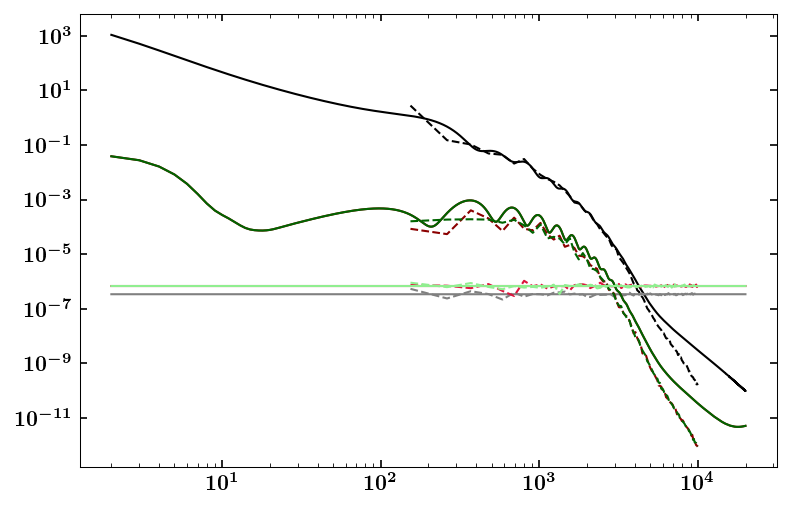

In [13]:
#get power spectrum of maps to ensure sims are fine
if not pol:
    tquiter = 1
else:
    tquiter = 3

ax = subplot(111, xscale = 'log', yscale = 'log')
colorarr = ['black', 'darkred', 'darkgreen']
colorarr_noise = ['gray', 'crimson', 'lightgreen']
cl_theory = [cl[0], cl[1], cl[1]]
for tqucntr in range(3):
    curr_el, curr_cl = flatsky.map2cl(mapparams, cmb_map[tqucntr])
    curr_el, curr_nl = flatsky.map2cl(mapparams, noise_map[tqucntr])
    
    plot(el, cl_theory[tqucntr], color = colorarr[tqucntr])#, label = r'CMB theory')
    plot(curr_el, curr_cl, color = colorarr[tqucntr], ls ='--')#, label = r'CMB map')
    plot(el, nl[tqucntr], color = colorarr_noise[tqucntr])#, label = r'Noise theory')
    plot(curr_el, curr_nl, color = colorarr_noise[tqucntr], ls ='--')#, label = r'Noise map')


In [14]:
#get covariance for inpainting
sigma_dic = inpaint.get_covariance(ra_grid, dec_grid, mapparams, el, cl_dic, bl, nl_dic, noofsims, mask_radius_inner, mask_radius_outer, low_pass_cutoff = 1)
print(sigma_dic.keys())



	calculating the covariance from simulations for inpainting
2698

		generating 1000 sims

			invert sigma_22 matrix (3564,3564) now

		covariance obtained
dict_keys(['sigma_22_inv', 'sigma_12'])


In [19]:
#perform inpainting
sim_map_dic = {}
if pol:
    sim_map_dic['T'], sim_map_dic['Q'], sim_map_dic['U'] = sim_map
else:
    sim_map_dic['T'] = sim_map
print(sim_map_dic.keys())    
cmb_inpainted_map, sim_map_inpainted, sim_map_filtered = inpaint.inpainting(sim_map_dic, ra_grid, dec_grid, mapparams, el, cl_dic, bl, nl_dic, noofsims, mask_radius_inner, mask_radius_outer, low_pass_cutoff = 1, mask_inner = mask_inner, sigma_dic = sigma_dic)


dict_keys(['T', 'Q', 'U'])


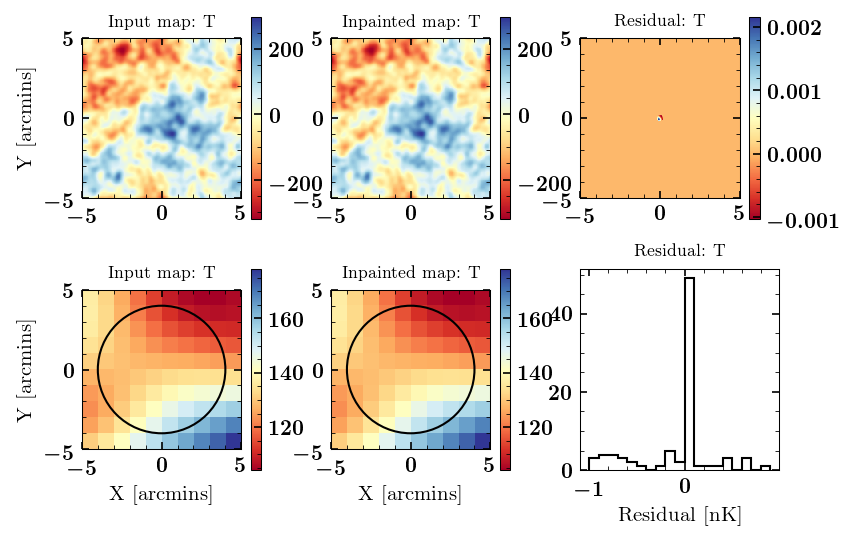

In [20]:
clf()
subplots_adjust(hspace = 0.25, wspace = 0.25)
tquarr = ['T', 'Q', 'U']
tqulen = len(cmb_inpainted_map)
#tr, tc = 2 * tqulen, 3
tr, tc = 2, 3
sbpl = 1
fsval = 8
for tqucntr in range(0,1): #plot T first
    subplot(tr, tc, sbpl);imshow(sim_map_filtered[tqucntr], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'Input map: %s' %(tquarr[tqucntr]), fontsize = fsval)
    ylabel('Y [arcmins]')
    sbpl+=1
    subplot(tr, tc, sbpl);imshow(sim_map_inpainted[tqucntr], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'Inpainted map: %s' %(tquarr[tqucntr]), fontsize = fsval)
    sbpl+=1
    residual = sim_map_filtered - sim_map_inpainted
    subplot(tr, tc, sbpl);imshow(residual[tqucntr], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'Residual: %s' %(tquarr[tqucntr]), fontsize = fsval)
    sbpl+=1

    #zooming in
    s, e = 95, 105
    x1, x2 = -(e-s)*dx/2.,(e-s)*dx/2.
    circle = Circle((0, 0), radius = mask_radius_inner, facecolor='None', edgecolor = 'black', lw = 1., ls = '-');
    ax=subplot(tr, tc, sbpl);imshow(sim_map_filtered[tqucntr, s:e, s:e], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'Input map: %s' %(tquarr[tqucntr]), fontsize = fsval)
    sbpl+=1
    ax.add_artist(circle)
    xlabel('X [arcmins]'); ylabel('Y [arcmins]')

    circle = Circle((0, 0), radius = mask_radius_inner, facecolor='None', edgecolor = 'black', lw = 1., ls = '-');
    ax=subplot(tr, tc, sbpl);imshow(sim_map_inpainted[tqucntr, s:e, s:e], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'Inpainted map: %s' %(tquarr[tqucntr]), fontsize = fsval)
    sbpl+=1
    ax.add_artist(circle)
    xlabel('X [arcmins]')

    residual_flatten = (residual[0, s:e, s:e].flatten())*1e3
    minval, maxval, delta = -1., 1., 0.1
    binbin = np.arange(minval, maxval, delta)
    subplot(tr, tc, sbpl);hist(residual_flatten, bins = binbin, histtype = 'step', color = 'black'); title(r'Residual: %s'  %(tquarr[tqucntr]), fontsize = fsval)
    sbpl+=1
    xlabel(r'Residual [nK]')

show()

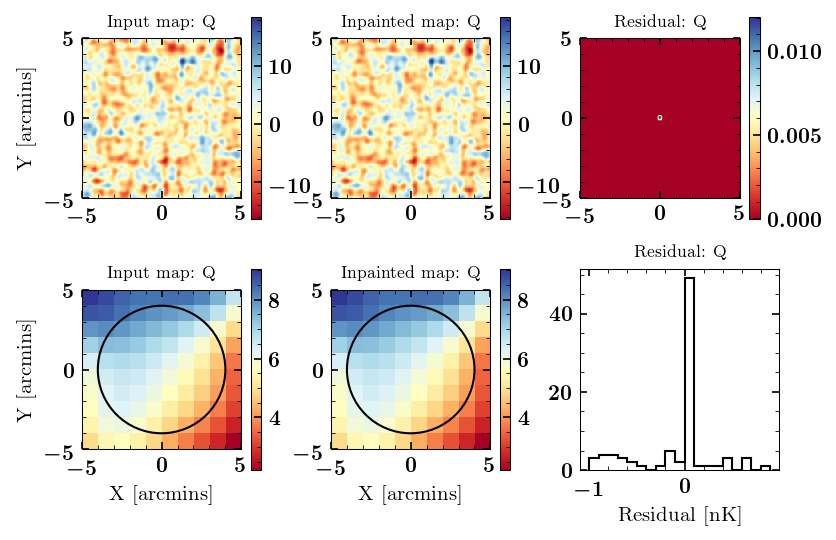

In [21]:
clf()
subplots_adjust(hspace = 0.25, wspace = 0.25)
tquarr = ['T', 'Q', 'U']
tqulen = len(cmb_inpainted_map)
#tr, tc = 2 * tqulen, 3
tr, tc = 2, 3
sbpl = 1
fsval = 8
for tqucntr in range(1,2): #plot Q now
    subplot(tr, tc, sbpl);imshow(sim_map_filtered[tqucntr], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'Input map: %s' %(tquarr[tqucntr]), fontsize = fsval)
    ylabel('Y [arcmins]')
    sbpl+=1
    subplot(tr, tc, sbpl);imshow(sim_map_inpainted[tqucntr], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'Inpainted map: %s' %(tquarr[tqucntr]), fontsize = fsval)
    sbpl+=1
    residual = sim_map_filtered - sim_map_inpainted
    subplot(tr, tc, sbpl);imshow(residual[tqucntr], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'Residual: %s' %(tquarr[tqucntr]), fontsize = fsval)
    sbpl+=1

    #zooming in
    s, e = 95, 105
    x1, x2 = -(e-s)*dx/2.,(e-s)*dx/2.
    circle = Circle((0, 0), radius = mask_radius_inner, facecolor='None', edgecolor = 'black', lw = 1., ls = '-');
    ax=subplot(tr, tc, sbpl);imshow(sim_map_filtered[tqucntr, s:e, s:e], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'Input map: %s' %(tquarr[tqucntr]), fontsize = fsval)
    sbpl+=1
    ax.add_artist(circle)
    xlabel('X [arcmins]'); ylabel('Y [arcmins]')

    circle = Circle((0, 0), radius = mask_radius_inner, facecolor='None', edgecolor = 'black', lw = 1., ls = '-');
    ax=subplot(tr, tc, sbpl);imshow(sim_map_inpainted[tqucntr, s:e, s:e], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'Inpainted map: %s' %(tquarr[tqucntr]), fontsize = fsval)
    sbpl+=1
    ax.add_artist(circle)
    xlabel('X [arcmins]')

    residual_flatten = (residual[0, s:e, s:e].flatten())*1e3
    minval, maxval, delta = -1., 1., 0.1
    binbin = np.arange(minval, maxval, delta)
    subplot(tr, tc, sbpl);hist(residual_flatten, bins = binbin, histtype = 'step', color = 'black'); title(r'Residual: %s'  %(tquarr[tqucntr]), fontsize = fsval)
    sbpl+=1
    xlabel(r'Residual [nK]')

show()

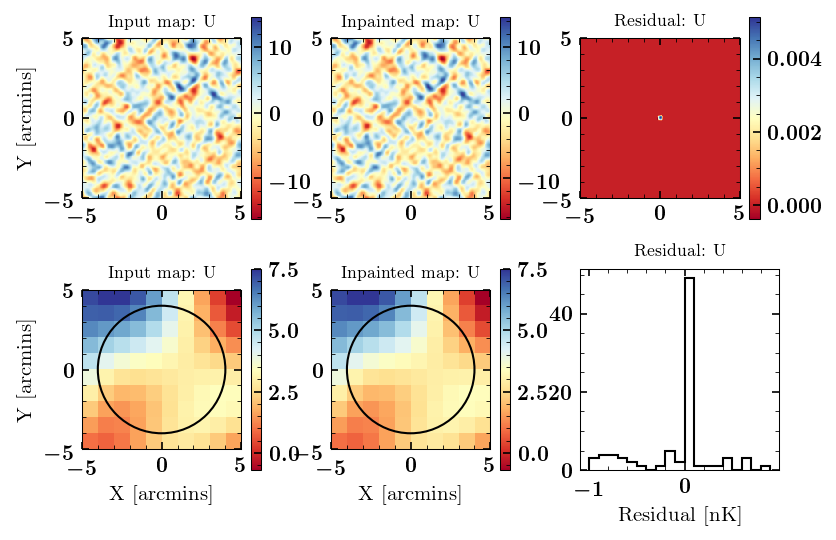

In [22]:
clf()
subplots_adjust(hspace = 0.25, wspace = 0.25)
tquarr = ['T', 'Q', 'U']
tqulen = len(cmb_inpainted_map)
#tr, tc = 2 * tqulen, 3
tr, tc = 2, 3
sbpl = 1
fsval = 8
for tqucntr in range(2,3): #plot U now
    subplot(tr, tc, sbpl);imshow(sim_map_filtered[tqucntr], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'Input map: %s' %(tquarr[tqucntr]), fontsize = fsval)
    ylabel('Y [arcmins]')
    sbpl+=1
    subplot(tr, tc, sbpl);imshow(sim_map_inpainted[tqucntr], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'Inpainted map: %s' %(tquarr[tqucntr]), fontsize = fsval)
    sbpl+=1
    residual = sim_map_filtered - sim_map_inpainted
    subplot(tr, tc, sbpl);imshow(residual[tqucntr], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'Residual: %s' %(tquarr[tqucntr]), fontsize = fsval)
    sbpl+=1

    #zooming in
    s, e = 95, 105
    x1, x2 = -(e-s)*dx/2.,(e-s)*dx/2.
    circle = Circle((0, 0), radius = mask_radius_inner, facecolor='None', edgecolor = 'black', lw = 1., ls = '-');
    ax=subplot(tr, tc, sbpl);imshow(sim_map_filtered[tqucntr, s:e, s:e], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'Input map: %s' %(tquarr[tqucntr]), fontsize = fsval)
    sbpl+=1
    ax.add_artist(circle)
    xlabel('X [arcmins]'); ylabel('Y [arcmins]')

    circle = Circle((0, 0), radius = mask_radius_inner, facecolor='None', edgecolor = 'black', lw = 1., ls = '-');
    ax=subplot(tr, tc, sbpl);imshow(sim_map_inpainted[tqucntr, s:e, s:e], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'Inpainted map: %s' %(tquarr[tqucntr]), fontsize = fsval)
    sbpl+=1
    ax.add_artist(circle)
    xlabel('X [arcmins]')

    residual_flatten = (residual[0, s:e, s:e].flatten())*1e3
    minval, maxval, delta = -1., 1., 0.1
    binbin = np.arange(minval, maxval, delta)
    subplot(tr, tc, sbpl);hist(residual_flatten, bins = binbin, histtype = 'step', color = 'black'); title(r'Residual: %s'  %(tquarr[tqucntr]), fontsize = fsval)
    sbpl+=1
    xlabel(r'Residual [nK]')

show()